## Effect of diffusivity and matching viscosity in tracer transport along several cross-sections 

Transports across several cross sections in the domain (See plot further down)

Advective tracer transport $\Phi_{Tadv}=C\vec{u}\cdot\vec{a}$ from model output diagnostics.

Diffusive tracer transport $\Phi_{Tdiff}$ from model output (Includes diffusion due to advection scheme)

| variable  | dims | units | description |
|:---------:|:---------:|:---------:|:---------:|
| UTRAC01   |   (T, Zmd000090, Y, Xp1) | Mol/L.m/s | Zonal Mass-Weighted Transp of Tr1 |
| VTRAC01   |   (T, Zmd000090, Yp1, X) | Mol/L.m/s | Meridional Mass-Weighted Transp of Tr1 |
| WTRAC01   |   (T, Zmd000090, Y, X)   | Mol/L.m/s | Vertical Mass-Weighted Transp of Tr1 |  
| ADVrTr01  |   (T, Zld000090, Y, X)   | Mol/L.m^3/s| Zonal Advective Flux of Tr1 |
| ADVxTr01  |   (T, Zmd000090, Y, Xp1) | Mol/L.m^3/s| Meridional Advective Flux of Tr1 |
| ADVyTr01  |   (T, Zmd000090, Yp1, X) | Mol/L.m^3/s| Vertical Advective Flux of Tr1 |
| DFrETr01  |   (T, Zld000090, Y, X)   | Mol/L.m^3/s| Vertical Diffusive Flux of Tr1 (Explicit part) |
| DFrITr01  |   (T, Zld000090, Y, X)   | Mol/L.m^3/s| Vertical Diffusive Flux of Tr1 (Implicit part) |
| DFxETr01  |   (T, Zmd000090, Y, Xp1) | Mol/L.m^3/s| Zonal Diffusive Flux of Tr1 |
| DFyETr01  |   (T, Zmd000090, Yp1, X) | Mol/L.m^3/s| Meridional Diffusive Flux of Tr1 |


In [2]:
import datetime as dtm      # Python's standard date and time library
import dateutil as dutil    # Powerful datetime extensions
import glob
from math import *
from matplotlib.dates import num2date
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
import xarray as xr


In [3]:
def calc_trac_transport_CS(flux_component, x_slice, y_slice, dim_name):
    '''
    INPUT:
    flux_component: xarray, flux component perpendicular to cross section (e.g. unstagger_xarray(flux38.V,'Yp1'))
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    dim_name: str, name of the dimension along which to sum.
    
    '''
    return (flux_component.isel(Yp1=y_slice, X=x_slice)).sum(dim=dim_name)

def calc_trac_transport_AS(flux_component, x_slice, y_slice, dim_name):
    '''
    INPUT:
    flux_component: xarray, Flux component perpendicular to cross section (e.g. unstagger_xarray(flux38.V,'Yp1'))
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    dim_name: str, name of the dimension along which to sum.
    
    '''
    return (flux_component.isel(Y=y_slice, Xp1=x_slice)).sum(dim=dim_name)
   

def unstagger_xarray(qty, index):
    """Interpolate u, v, or w component values to values at grid cell centres.
    
    Named indexing requires that input arrays are XArray DataArrays.

    :arg qty: u, v, or w component values
    :type qty: :py:class:`xarray.DataArray`
    
    :arg index: index name along which to centre
        (generally one of 'gridX', 'gridY', or 'depth')
    :type index: str

    :returns qty: u, v, or w component values at grid cell centres
    :rtype: :py:class:`xarray.DataArray`
    """
    
    qty = (qty + qty.shift(**{index: 1})) / 2
    
    return qty

def fig_looks(ax, title = 'Cross-shelf transport'):
    '''define aesthetics of transport plots'''
    sns.set_style(style='whitegrid')
    sns.set_context('talk')

    ax.set_ylabel('tracer transport [$Mol/l.m^3s^{-1}$]')
    ax.set_xlabel('Time [$s$]')
    ax.legend(loc=0)
    ax.set_title(title)
    
    return(ax)
    

In [4]:
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
flux_file38 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/FluxTR01Glob.nc'
flux_file43 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run43/FluxTR01Glob.nc'
flux_file36 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run36/FluxTR01Glob.nc'
flux_file37 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run37/FluxTR01Glob.nc'

gridNoC_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc'
flux_file50 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run50/FluxTR01Glob.nc'
flux_file40 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run40/FluxTR01Glob.nc'
flux_file41 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run41/FluxTR01Glob.nc'
flux_file42 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/FluxTR01Glob.nc'

grid = xr.open_dataset(grid_file)
flux38 = xr.open_dataset(flux_file38)
flux43 = xr.open_dataset(flux_file43)
flux36 = xr.open_dataset(flux_file36)
flux37 = xr.open_dataset(flux_file37)

gridNoC = xr.open_dataset(gridNoC_file)
flux42 = xr.open_dataset(flux_file42)
flux50 = xr.open_dataset(flux_file50)
flux40 = xr.open_dataset(flux_file40)
flux41 = xr.open_dataset(flux_file41)


### Cross-sections

In [5]:
CS1_x_slice = slice(0, 59)
CS2_x_slice = slice(60, 119)
CS3_x_slice = slice(120, 239)
CS4_x_slice = slice(240, 299)
CS5_x_slice = slice(300, 359)

CS1_y_ind = 227
CS1b_y_ind = 267
CS1c_y_ind = 297
CS1d_y_ind = 359

AS1_y_slice = slice(227, 266)
AS2_y_slice = slice(267, 298)
AS3_y_slice = slice(299, 359)

AS1_x_ind = 59
AS1b_x_ind = 119
AS1c_x_ind = 239
AS1d_x_ind = 299

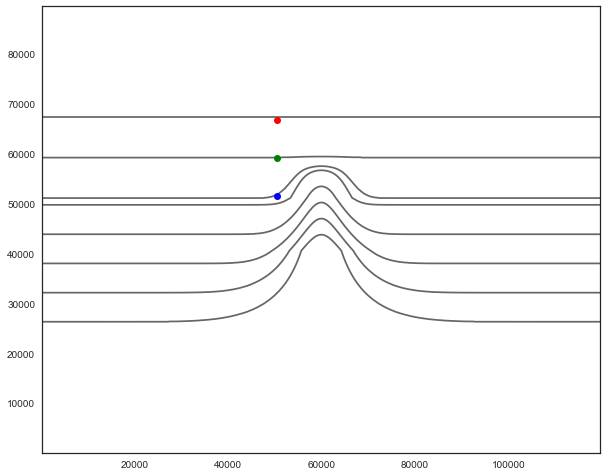

In [6]:
sns.set_style(style='white')
fig, ax = plt.subplots(1, 1, figsize=(10,8))

ax.contour(grid.X,grid.Y,grid.Depth,[50,100,150,200,400,600,800,1000], colors='0.4')
ax.plot(grid.X[120],grid.Y[227], 'bo')
ax.plot(grid.X[120],grid.Y[267], 'go')
ax.plot(grid.X[120],grid.Y[297], 'ro')

In [6]:
advCS1_flux38 = calc_trac_transport_CS(unstagger_xarray(flux38.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS2_flux38 = calc_trac_transport_CS(unstagger_xarray(flux38.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS3_flux38 = calc_trac_transport_CS(unstagger_xarray(flux38.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS4_flux38 = calc_trac_transport_CS(unstagger_xarray(flux38.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS5_flux38 = calc_trac_transport_CS(unstagger_xarray(flux38.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

advCS1_flux43 = calc_trac_transport_CS(unstagger_xarray(flux43.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS2_flux43 = calc_trac_transport_CS(unstagger_xarray(flux43.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS3_flux43 = calc_trac_transport_CS(unstagger_xarray(flux43.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS4_flux43 = calc_trac_transport_CS(unstagger_xarray(flux43.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS5_flux43 = calc_trac_transport_CS(unstagger_xarray(flux43.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

advCS1_flux36 = calc_trac_transport_CS(unstagger_xarray(flux36.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS2_flux36 = calc_trac_transport_CS(unstagger_xarray(flux36.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS3_flux36 = calc_trac_transport_CS(unstagger_xarray(flux36.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS4_flux36 = calc_trac_transport_CS(unstagger_xarray(flux36.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS5_flux36 = calc_trac_transport_CS(unstagger_xarray(flux36.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

advCS1_flux37 = calc_trac_transport_CS(unstagger_xarray(flux37.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS2_flux37 = calc_trac_transport_CS(unstagger_xarray(flux37.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS3_flux37 = calc_trac_transport_CS(unstagger_xarray(flux37.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS4_flux37 = calc_trac_transport_CS(unstagger_xarray(flux37.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS5_flux37 = calc_trac_transport_CS(unstagger_xarray(flux37.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')



In [7]:
advCS1_flux42 = calc_trac_transport_CS(unstagger_xarray(flux42.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS2_flux42 = calc_trac_transport_CS(unstagger_xarray(flux42.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS3_flux42 = calc_trac_transport_CS(unstagger_xarray(flux42.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS4_flux42 = calc_trac_transport_CS(unstagger_xarray(flux42.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS5_flux42 = calc_trac_transport_CS(unstagger_xarray(flux42.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

advCS1_flux50 = calc_trac_transport_CS(unstagger_xarray(flux50.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS2_flux50 = calc_trac_transport_CS(unstagger_xarray(flux50.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS3_flux50 = calc_trac_transport_CS(unstagger_xarray(flux50.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS4_flux50 = calc_trac_transport_CS(unstagger_xarray(flux50.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS5_flux50 = calc_trac_transport_CS(unstagger_xarray(flux50.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

advCS1_flux40 = calc_trac_transport_CS(unstagger_xarray(flux40.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS2_flux40 = calc_trac_transport_CS(unstagger_xarray(flux40.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS3_flux40 = calc_trac_transport_CS(unstagger_xarray(flux40.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS4_flux40 = calc_trac_transport_CS(unstagger_xarray(flux40.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS5_flux40 = calc_trac_transport_CS(unstagger_xarray(flux40.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

advCS1_flux41 = calc_trac_transport_CS(unstagger_xarray(flux41.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS2_flux41 = calc_trac_transport_CS(unstagger_xarray(flux41.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS3_flux41 = calc_trac_transport_CS(unstagger_xarray(flux41.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS4_flux41 = calc_trac_transport_CS(unstagger_xarray(flux41.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
advCS5_flux41 = calc_trac_transport_CS(unstagger_xarray(flux41.ADVyTr01.isel(Zmd000090=slice(20,90)),'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')



In [8]:
difCS1_flux38 = calc_trac_transport_CS(unstagger_xarray(flux38.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS2_flux38 = calc_trac_transport_CS(unstagger_xarray(flux38.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS3_flux38 = calc_trac_transport_CS(unstagger_xarray(flux38.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS4_flux38 = calc_trac_transport_CS(unstagger_xarray(flux38.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS5_flux38 = calc_trac_transport_CS(unstagger_xarray(flux38.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

difCS1_flux43 = calc_trac_transport_CS(unstagger_xarray(flux43.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS2_flux43 = calc_trac_transport_CS(unstagger_xarray(flux43.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS3_flux43 = calc_trac_transport_CS(unstagger_xarray(flux43.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS4_flux43 = calc_trac_transport_CS(unstagger_xarray(flux43.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS5_flux43 = calc_trac_transport_CS(unstagger_xarray(flux43.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

difCS1_flux36 = calc_trac_transport_CS(unstagger_xarray(flux36.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS2_flux36 = calc_trac_transport_CS(unstagger_xarray(flux36.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS3_flux36 = calc_trac_transport_CS(unstagger_xarray(flux36.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS4_flux36 = calc_trac_transport_CS(unstagger_xarray(flux36.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS5_flux36 = calc_trac_transport_CS(unstagger_xarray(flux36.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

difCS1_flux37 = calc_trac_transport_CS(unstagger_xarray(flux37.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS2_flux37 = calc_trac_transport_CS(unstagger_xarray(flux37.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS3_flux37 = calc_trac_transport_CS(unstagger_xarray(flux37.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS4_flux37 = calc_trac_transport_CS(unstagger_xarray(flux37.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS5_flux37 = calc_trac_transport_CS(unstagger_xarray(flux37.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')



In [1]:
difCS1_flux42 = calc_trac_transport_CS(unstagger_xarray(flux42.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS2_flux42 = calc_trac_transport_CS(unstagger_xarray(flux42.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS3_flux42 = calc_trac_transport_CS(unstagger_xarray(flux42.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS4_flux42 = calc_trac_transport_CS(unstagger_xarray(flux42.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS5_flux42 = calc_trac_transport_CS(unstagger_xarray(flux42.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

difCS1_flux50 = calc_trac_transport_CS(unstagger_xarray(flux50.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS2_flux50 = calc_trac_transport_CS(unstagger_xarray(flux50.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS3_flux50 = calc_trac_transport_CS(unstagger_xarray(flux50.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS4_flux50 = calc_trac_transport_CS(unstagger_xarray(flux50.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS5_flux50 = calc_trac_transport_CS(unstagger_xarray(flux50.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

difCS1_flux40 = calc_trac_transport_CS(unstagger_xarray(flux40.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS2_flux40 = calc_trac_transport_CS(unstagger_xarray(flux40.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS3_flux40 = calc_trac_transport_CS(unstagger_xarray(flux40.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS4_flux40 = calc_trac_transport_CS(unstagger_xarray(flux40.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS5_flux40 = calc_trac_transport_CS(unstagger_xarray(flux40.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')

difCS1_flux41 = calc_trac_transport_CS(unstagger_xarray(flux41.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS2_flux41 = calc_trac_transport_CS(unstagger_xarray(flux41.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS3_flux41 = calc_trac_transport_CS(unstagger_xarray(flux41.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS4_flux41 = calc_trac_transport_CS(unstagger_xarray(flux41.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')
difCS5_flux41 = calc_trac_transport_CS(unstagger_xarray(flux41.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X').sum(dim='Zmd000090')



NameError: name 'calc_trac_transport_CS' is not defined

### Cross-shelf sections

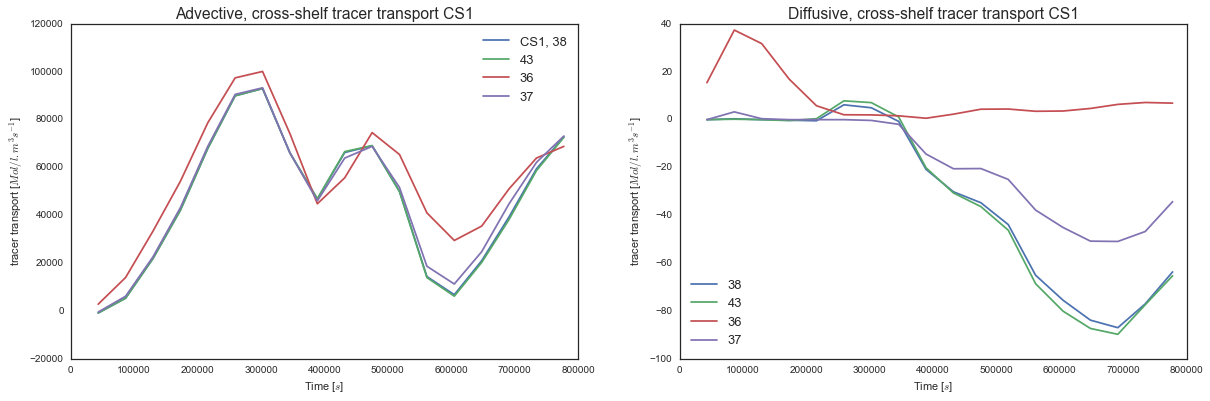

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advCS1_flux38).plot(ax=ax[0], label = 'CS1, 38')
(advCS1_flux43).plot(ax=ax[0], label = '43')
(advCS1_flux36).plot(ax=ax[0], label = '36')
(advCS1_flux37).plot(ax=ax[0], label = '37')

(difCS1_flux38).plot(ax=ax[1], label = '38')
(difCS1_flux43).plot(ax=ax[1], label = '43')
(difCS1_flux36).plot(ax=ax[1], label = '36')
(difCS1_flux37).plot(ax=ax[1], label = '37')

ax[0] = fig_looks(ax[0],title='Advective, cross-shelf tracer transport CS1')
ax[1] = fig_looks(ax[1],title='Diffusive, cross-shelf tracer transport CS1')

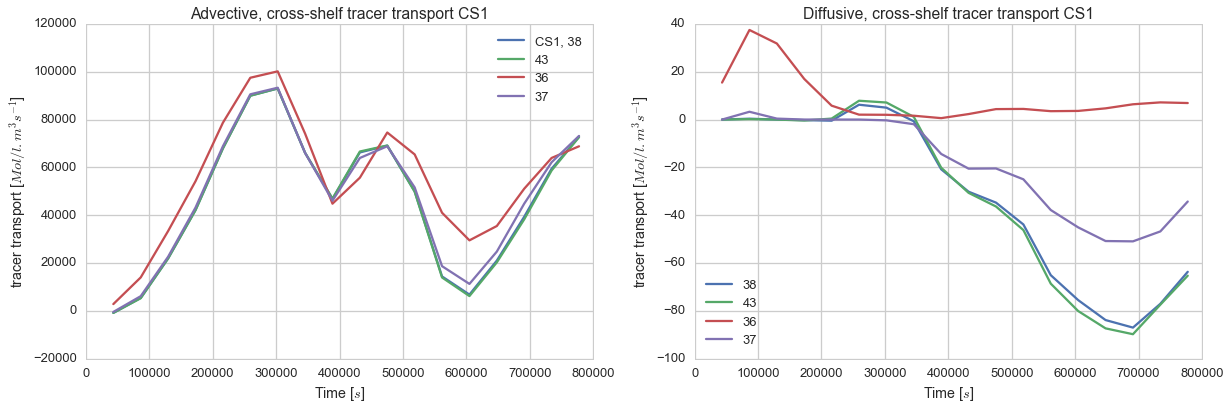

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advCS1_flux38).plot(ax=ax[0], label = 'CS1, 38')
(advCS1_flux43).plot(ax=ax[0], label = '43')
(advCS1_flux36).plot(ax=ax[0], label = '36')
(advCS1_flux37).plot(ax=ax[0], label = '37')


(difCS1_flux38).plot(ax=ax[1], label = '38')
(difCS1_flux43).plot(ax=ax[1], label = '43')
(difCS1_flux36).plot(ax=ax[1], label = '36')
(difCS1_flux37).plot(ax=ax[1], label = '37')

ax[0] = fig_looks(ax[0],title='Advective, cross-shelf tracer transport CS1')
ax[1] = fig_looks(ax[1],title='Diffusive, cross-shelf tracer transport CS1')

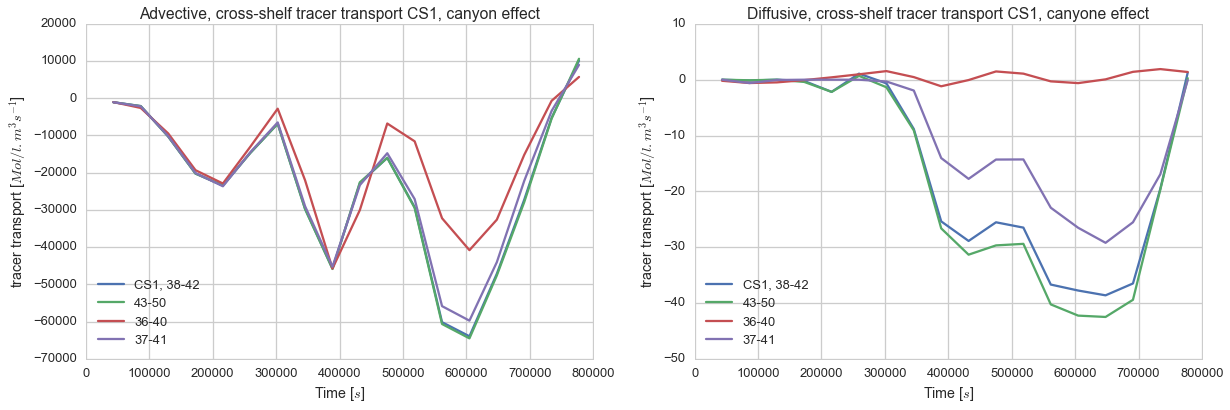

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advCS1_flux38-advCS1_flux42).plot(ax=ax[0], label = 'CS1, 38-42')
(advCS1_flux43-advCS1_flux50).plot(ax=ax[0], label = '43-50')
(advCS1_flux36-advCS1_flux40).plot(ax=ax[0], label = '36-40')
(advCS1_flux37-advCS1_flux41).plot(ax=ax[0], label = '37-41')


(difCS1_flux38-difCS1_flux42).plot(ax=ax[1], label = 'CS1, 38-42')
(difCS1_flux43-difCS1_flux50).plot(ax=ax[1], label = '43-50')
(difCS1_flux36-difCS1_flux40).plot(ax=ax[1], label = '36-40')
(difCS1_flux37-difCS1_flux41).plot(ax=ax[1], label = '37-41')


ax[0] = fig_looks(ax[0],title='Advective, cross-shelf tracer transport CS1, canyon effect')
ax[1] = fig_looks(ax[1],title='Diffusive, cross-shelf tracer transport CS1, canyone effect')

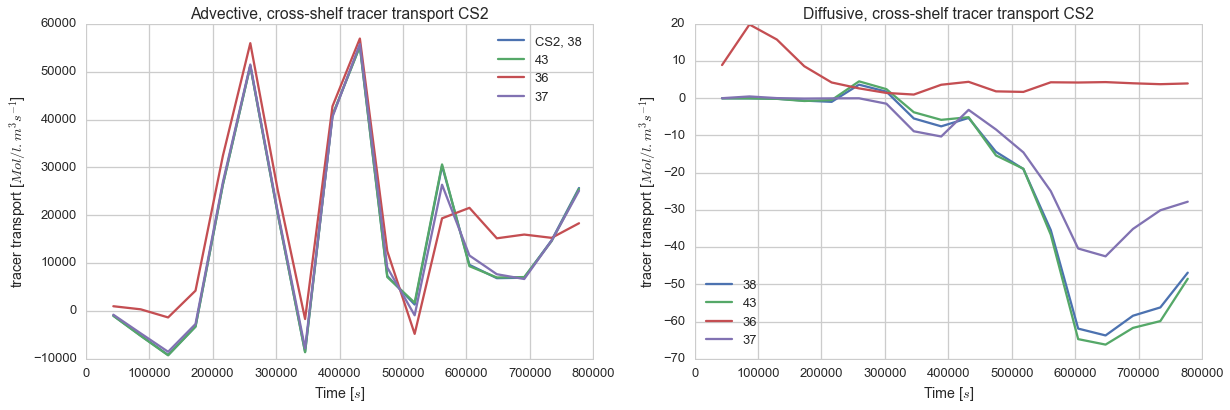

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advCS2_flux38).plot(ax=ax[0], label = 'CS2, 38')
(advCS2_flux43).plot(ax=ax[0], label = '43')
(advCS2_flux36).plot(ax=ax[0], label = '36')
(advCS2_flux37).plot(ax=ax[0], label = '37')


(difCS2_flux38).plot(ax=ax[1], label = '38')
(difCS2_flux43).plot(ax=ax[1], label = '43')
(difCS2_flux36).plot(ax=ax[1], label = '36')
(difCS2_flux37).plot(ax=ax[1], label = '37')


ax[0] = fig_looks(ax[0],title='Advective, cross-shelf tracer transport CS2')
ax[1] = fig_looks(ax[1],title='Diffusive, cross-shelf tracer transport CS2')

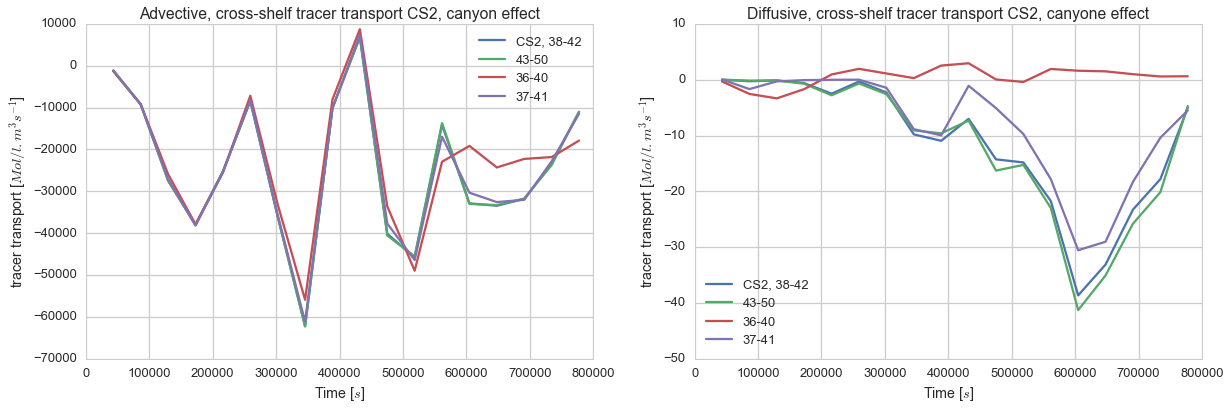

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advCS2_flux38-advCS2_flux42).plot(ax=ax[0], label = 'CS2, 38-42')
(advCS2_flux43-advCS2_flux50).plot(ax=ax[0], label = '43-50')
(advCS2_flux36-advCS2_flux40).plot(ax=ax[0], label = '36-40')
(advCS2_flux37-advCS2_flux41).plot(ax=ax[0], label = '37-41')

(difCS2_flux38-difCS2_flux42).plot(ax=ax[1], label = 'CS2, 38-42')
(difCS2_flux43-difCS2_flux50).plot(ax=ax[1], label = '43-50')
(difCS2_flux36-difCS2_flux40).plot(ax=ax[1], label = '36-40')
(difCS2_flux37-difCS2_flux41).plot(ax=ax[1], label = '37-41')


ax[0] = fig_looks(ax[0],title='Advective, cross-shelf tracer transport CS2, canyon effect')
ax[1] = fig_looks(ax[1],title='Diffusive, cross-shelf tracer transport CS2, canyone effect')

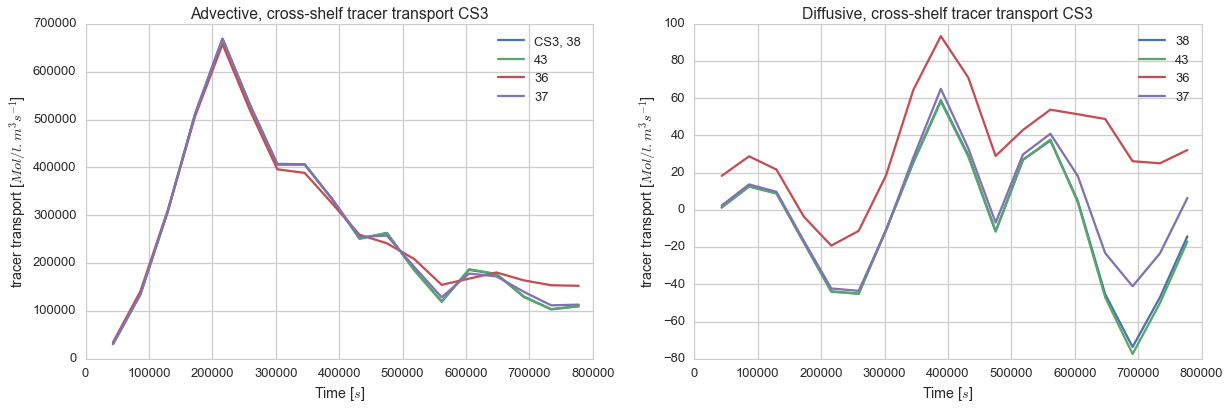

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advCS3_flux38).plot(ax=ax[0], label = 'CS3, 38')
(advCS3_flux43).plot(ax=ax[0], label = '43')
(advCS3_flux36).plot(ax=ax[0], label = '36')
(advCS3_flux37).plot(ax=ax[0], label = '37')


(difCS3_flux38).plot(ax=ax[1], label = '38')
(difCS3_flux43).plot(ax=ax[1], label = '43')
(difCS3_flux36).plot(ax=ax[1], label = '36')
(difCS3_flux37).plot(ax=ax[1], label = '37')


ax[0] = fig_looks(ax[0],title='Advective, cross-shelf tracer transport CS3')
ax[1] = fig_looks(ax[1],title='Diffusive, cross-shelf tracer transport CS3')

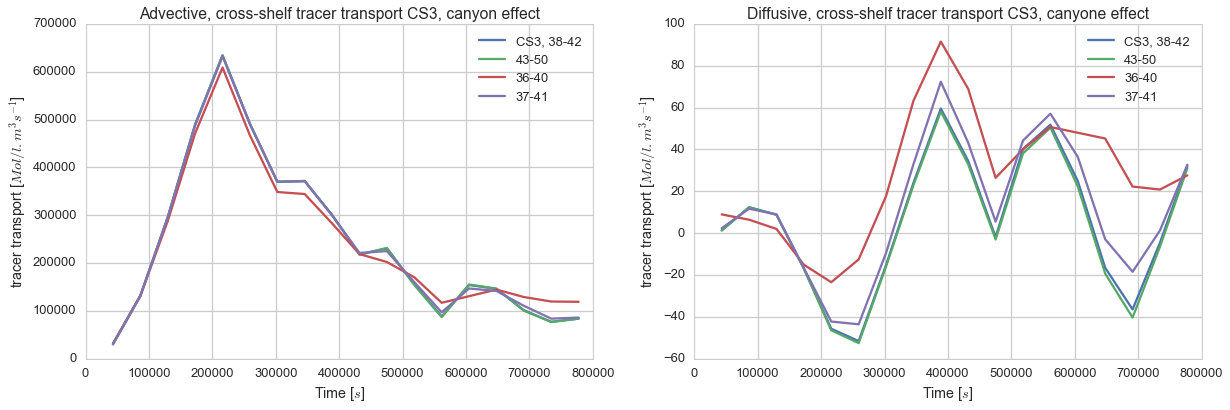

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advCS3_flux38-advCS3_flux42).plot(ax=ax[0], label = 'CS3, 38-42')
(advCS3_flux43-advCS3_flux50).plot(ax=ax[0], label = '43-50')
(advCS3_flux36-advCS3_flux40).plot(ax=ax[0], label = '36-40')
(advCS3_flux37-advCS3_flux41).plot(ax=ax[0], label = '37-41')

(difCS3_flux38-difCS3_flux42).plot(ax=ax[1], label = 'CS3, 38-42')
(difCS3_flux43-difCS3_flux50).plot(ax=ax[1], label = '43-50')
(difCS3_flux36-difCS3_flux40).plot(ax=ax[1], label = '36-40')
(difCS3_flux37-difCS3_flux41).plot(ax=ax[1], label = '37-41')


ax[0] = fig_looks(ax[0],title='Advective, cross-shelf tracer transport CS3, canyon effect')
ax[1] = fig_looks(ax[1],title='Diffusive, cross-shelf tracer transport CS3, canyone effect')

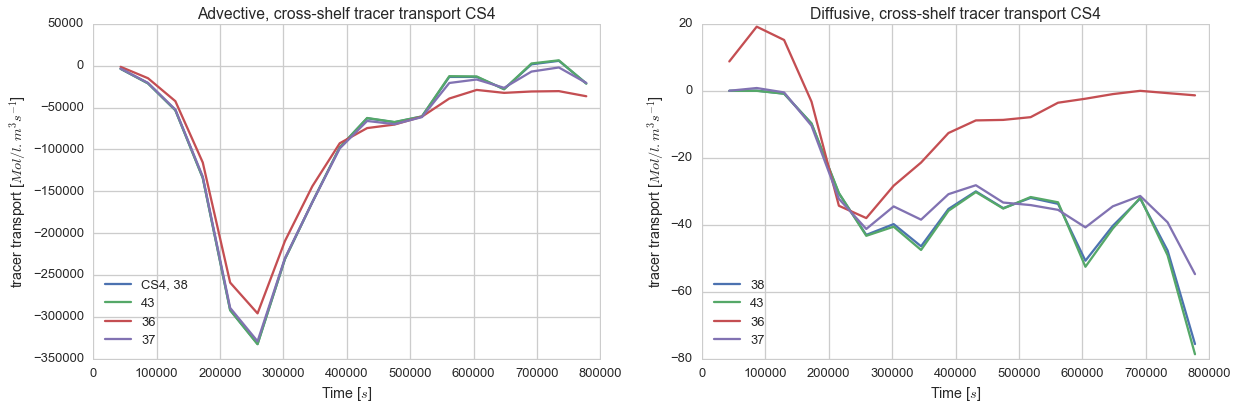

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advCS4_flux38).plot(ax=ax[0], label = 'CS4, 38')
(advCS4_flux43).plot(ax=ax[0], label = '43')
(advCS4_flux36).plot(ax=ax[0], label = '36')
(advCS4_flux37).plot(ax=ax[0], label = '37')


(difCS4_flux38).plot(ax=ax[1], label = '38')
(difCS4_flux43).plot(ax=ax[1], label = '43')
(difCS4_flux36).plot(ax=ax[1], label = '36')
(difCS4_flux37).plot(ax=ax[1], label = '37')


ax[0] = fig_looks(ax[0],title='Advective, cross-shelf tracer transport CS4')
ax[1] = fig_looks(ax[1],title='Diffusive, cross-shelf tracer transport CS4')

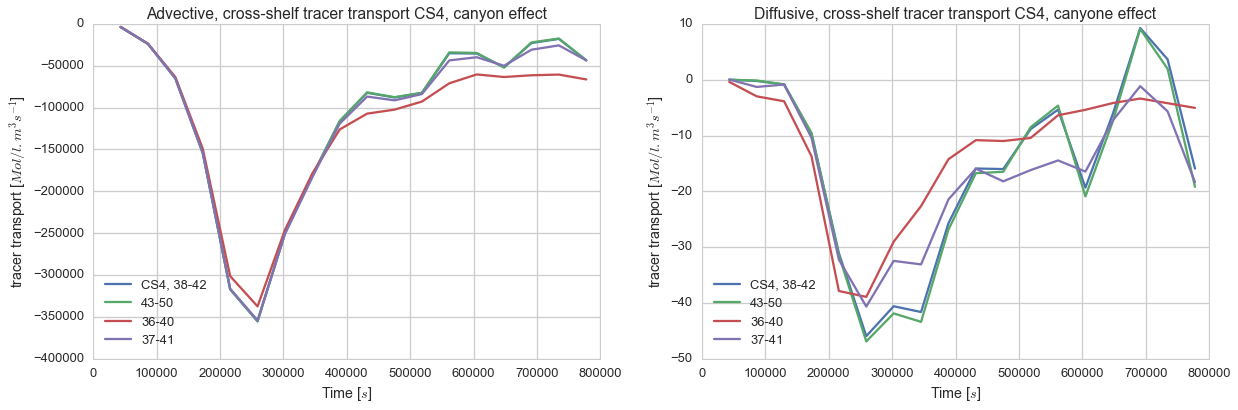

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advCS4_flux38-advCS4_flux42).plot(ax=ax[0], label = 'CS4, 38-42')
(advCS4_flux43-advCS4_flux50).plot(ax=ax[0], label = '43-50')
(advCS4_flux36-advCS4_flux40).plot(ax=ax[0], label = '36-40')
(advCS4_flux37-advCS4_flux41).plot(ax=ax[0], label = '37-41')


(difCS4_flux38-difCS4_flux42).plot(ax=ax[1], label = 'CS4, 38-42')
(difCS4_flux43-difCS4_flux50).plot(ax=ax[1], label = '43-50')
(difCS4_flux36-difCS4_flux40).plot(ax=ax[1], label = '36-40')
(difCS4_flux37-difCS4_flux41).plot(ax=ax[1], label = '37-41')


ax[0] = fig_looks(ax[0],title='Advective, cross-shelf tracer transport CS4, canyon effect')
ax[1] = fig_looks(ax[1],title='Diffusive, cross-shelf tracer transport CS4, canyone effect')

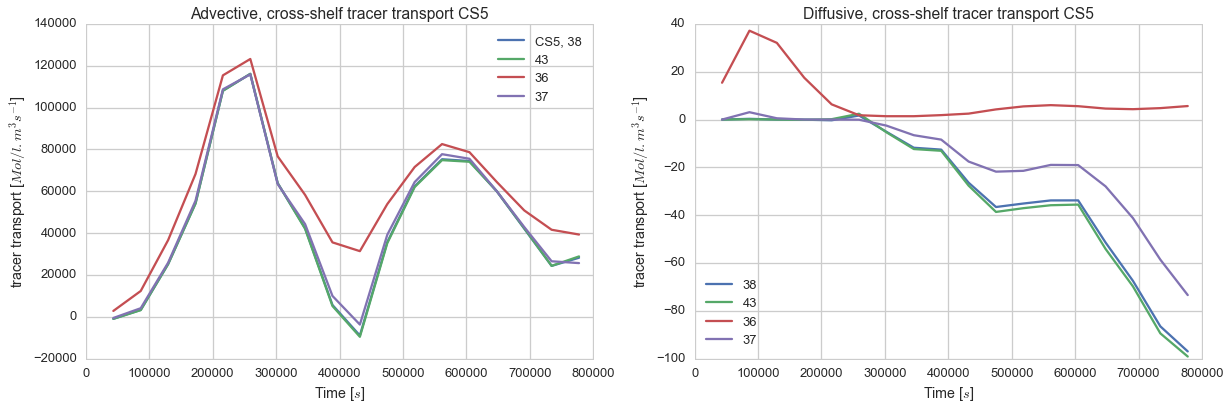

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advCS5_flux38).plot(ax=ax[0], label = 'CS5, 38')
(advCS5_flux43).plot(ax=ax[0], label = '43')
(advCS5_flux36).plot(ax=ax[0], label = '36')
(advCS5_flux37).plot(ax=ax[0], label = '37')


(difCS5_flux38).plot(ax=ax[1], label = '38')
(difCS5_flux43).plot(ax=ax[1], label = '43')
(difCS5_flux36).plot(ax=ax[1], label = '36')
(difCS5_flux37).plot(ax=ax[1], label = '37')

ax[0] = fig_looks(ax[0],title='Advective, cross-shelf tracer transport CS5')
ax[1] = fig_looks(ax[1],title='Diffusive, cross-shelf tracer transport CS5')

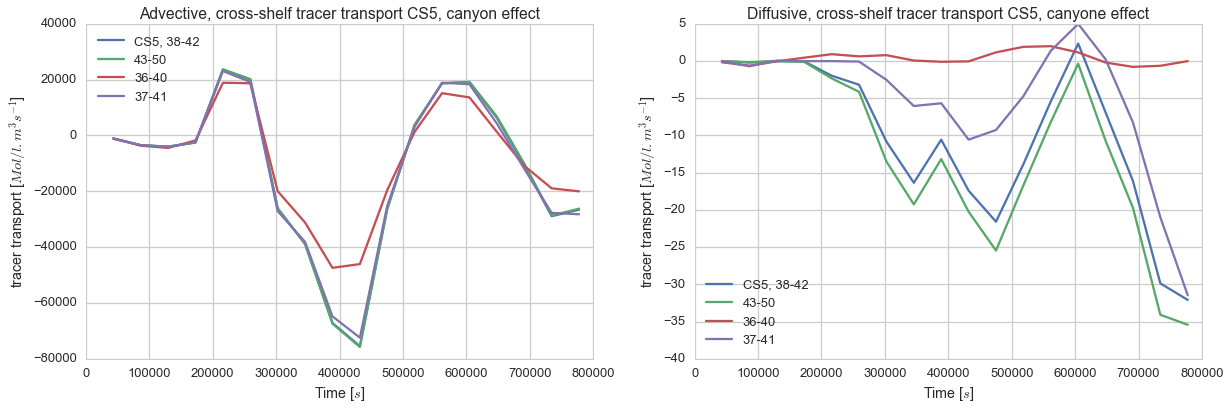

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advCS5_flux38-advCS5_flux42).plot(ax=ax[0], label = 'CS5, 38-42')
(advCS5_flux43-advCS5_flux50).plot(ax=ax[0], label = '43-50')
(advCS5_flux36-advCS5_flux40).plot(ax=ax[0], label = '36-40')
(advCS5_flux37-advCS5_flux41).plot(ax=ax[0], label = '37-41')


(difCS5_flux38-difCS5_flux42).plot(ax=ax[1], label = 'CS5, 38-42')
(difCS5_flux43-difCS5_flux50).plot(ax=ax[1], label = '43-50')
(difCS5_flux36-difCS5_flux40).plot(ax=ax[1], label = '36-40')
(difCS5_flux37-difCS5_flux41).plot(ax=ax[1], label = '37-41')


ax[0] = fig_looks(ax[0],title='Advective, cross-shelf tracer transport CS5, canyon effect')
ax[1] = fig_looks(ax[1],title='Diffusive, cross-shelf tracer transport CS5, canyone effect')

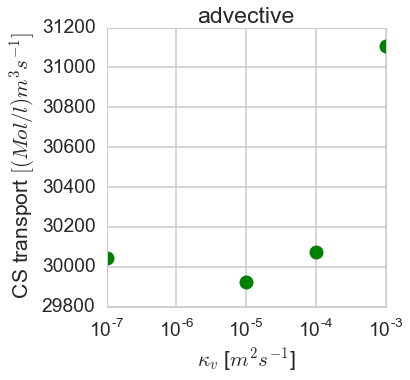

In [23]:
sns.set_context('poster',font_scale=1.2)

total43 = (advCS5_flux43 + advCS4_flux43 + advCS3_flux43 + advCS2_flux43 + advCS1_flux43-
           (advCS5_flux50 + advCS4_flux50 + advCS3_flux50 + advCS2_flux50 + advCS1_flux50)).isel(T=slice(6,19)).mean(dim='T')
total38 = (advCS5_flux38 + advCS4_flux38 + advCS3_flux38 + advCS2_flux38 + advCS1_flux38-
           (advCS5_flux42 + advCS4_flux42 + advCS3_flux42 + advCS2_flux42 + advCS1_flux42)).isel(T=slice(6,19)).mean(dim='T')
total36 = (advCS5_flux36 + advCS4_flux36 + advCS3_flux36 + advCS2_flux36 + advCS1_flux36-
           (advCS5_flux40 + advCS4_flux40 + advCS3_flux40 + advCS2_flux40 + advCS1_flux40)).isel(T=slice(6,19)).mean(dim='T')
total37 = (advCS5_flux37 + advCS4_flux37 + advCS3_flux37 + advCS2_flux37 + advCS1_flux37-
           (advCS5_flux41 + advCS4_flux41 + advCS3_flux41 + advCS2_flux41 + advCS1_flux41)).isel(T=slice(6,19)).mean(dim='T')

datasets = [total43,total38,total37,total36]

Kv = [1E-7,1E-5,1E-4,1E-3]

fig,ax = plt.subplots(1,1,figsize=(5,5))

for data,ii in zip(datasets,range(len(Kv)+1)):
    
    ax.plot(Kv[ii],data,'go',markersize=14)
    ax.set_xscale("log", nonposx='clip')
    
ax.set_ylabel(' CS transport $[(Mol/l)m^3s^{-1}]$')
ax.set_xlabel('$\kappa_v$ [$m^2s^{-1}$]')
ax.set_title('advective')


plt.tight_layout
plt.plot()

fig.savefig('adv_trac_trans_diff_new_visc.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


## Alongshore transports

### Downstream, near canyon rim

In [24]:
advAS1c_flux38 = calc_trac_transport_AS(unstagger_xarray(flux38.ADVxTr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
advAS2c_flux38 = calc_trac_transport_AS(unstagger_xarray(flux38.ADVxTr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
advAS3c_flux38 = calc_trac_transport_AS(unstagger_xarray(flux38.ADVxTr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

difAS1c_flux38 = calc_trac_transport_AS(unstagger_xarray(flux38.DFxETr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
difAS2c_flux38 = calc_trac_transport_AS(unstagger_xarray(flux38.DFxETr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
difAS3c_flux38 = calc_trac_transport_AS(unstagger_xarray(flux38.DFxETr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

advAS1c_flux43 = calc_trac_transport_AS(unstagger_xarray(flux43.ADVxTr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
advAS2c_flux43 = calc_trac_transport_AS(unstagger_xarray(flux43.ADVxTr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
advAS3c_flux43 = calc_trac_transport_AS(unstagger_xarray(flux43.ADVxTr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

difAS1c_flux43 = calc_trac_transport_AS(unstagger_xarray(flux43.DFxETr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
difAS2c_flux43 = calc_trac_transport_AS(unstagger_xarray(flux43.DFxETr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
difAS3c_flux43 = calc_trac_transport_AS(unstagger_xarray(flux43.DFxETr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

advAS1c_flux36 = calc_trac_transport_AS(unstagger_xarray(flux36.ADVxTr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
advAS2c_flux36 = calc_trac_transport_AS(unstagger_xarray(flux36.ADVxTr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
advAS3c_flux36 = calc_trac_transport_AS(unstagger_xarray(flux36.ADVxTr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

difAS1c_flux36 = calc_trac_transport_AS(unstagger_xarray(flux36.DFxETr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
difAS2c_flux36 = calc_trac_transport_AS(unstagger_xarray(flux36.DFxETr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
difAS3c_flux36 = calc_trac_transport_AS(unstagger_xarray(flux36.DFxETr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

advAS1c_flux37 = calc_trac_transport_AS(unstagger_xarray(flux37.ADVxTr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
advAS2c_flux37 = calc_trac_transport_AS(unstagger_xarray(flux37.ADVxTr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
advAS3c_flux37 = calc_trac_transport_AS(unstagger_xarray(flux37.ADVxTr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

difAS1c_flux37 = calc_trac_transport_AS(unstagger_xarray(flux37.DFxETr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
difAS2c_flux37 = calc_trac_transport_AS(unstagger_xarray(flux37.DFxETr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
difAS3c_flux37 = calc_trac_transport_AS(unstagger_xarray(flux37.DFxETr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')


In [25]:
advAS1c_flux42 = calc_trac_transport_AS(unstagger_xarray(flux42.ADVxTr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
advAS2c_flux42 = calc_trac_transport_AS(unstagger_xarray(flux42.ADVxTr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
advAS3c_flux42 = calc_trac_transport_AS(unstagger_xarray(flux42.ADVxTr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

difAS1c_flux42 = calc_trac_transport_AS(unstagger_xarray(flux42.DFxETr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
difAS2c_flux42 = calc_trac_transport_AS(unstagger_xarray(flux42.DFxETr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
difAS3c_flux42 = calc_trac_transport_AS(unstagger_xarray(flux42.DFxETr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

advAS1c_flux50 = calc_trac_transport_AS(unstagger_xarray(flux50.ADVxTr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
advAS2c_flux50 = calc_trac_transport_AS(unstagger_xarray(flux50.ADVxTr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
advAS3c_flux50 = calc_trac_transport_AS(unstagger_xarray(flux50.ADVxTr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

difAS1c_flux50 = calc_trac_transport_AS(unstagger_xarray(flux50.DFxETr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
difAS2c_flux50 = calc_trac_transport_AS(unstagger_xarray(flux50.DFxETr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
difAS3c_flux50 = calc_trac_transport_AS(unstagger_xarray(flux50.DFxETr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

advAS1c_flux40 = calc_trac_transport_AS(unstagger_xarray(flux40.ADVxTr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
advAS2c_flux40 = calc_trac_transport_AS(unstagger_xarray(flux40.ADVxTr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
advAS3c_flux40 = calc_trac_transport_AS(unstagger_xarray(flux40.ADVxTr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

difAS1c_flux40 = calc_trac_transport_AS(unstagger_xarray(flux40.DFxETr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
difAS2c_flux40 = calc_trac_transport_AS(unstagger_xarray(flux40.DFxETr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
difAS3c_flux40 = calc_trac_transport_AS(unstagger_xarray(flux40.DFxETr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

advAS1c_flux41 = calc_trac_transport_AS(unstagger_xarray(flux41.ADVxTr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
advAS2c_flux41 = calc_trac_transport_AS(unstagger_xarray(flux41.ADVxTr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
advAS3c_flux41 = calc_trac_transport_AS(unstagger_xarray(flux41.ADVxTr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')

difAS1c_flux41 = calc_trac_transport_AS(unstagger_xarray(flux41.DFxETr01,'Xp1'), AS1c_x_ind, AS1_y_slice, 'Y')
difAS2c_flux41 = calc_trac_transport_AS(unstagger_xarray(flux41.DFxETr01,'Xp1'), AS1c_x_ind, AS2_y_slice, 'Y')
difAS3c_flux41 = calc_trac_transport_AS(unstagger_xarray(flux41.DFxETr01,'Xp1'), AS1c_x_ind, AS3_y_slice, 'Y')



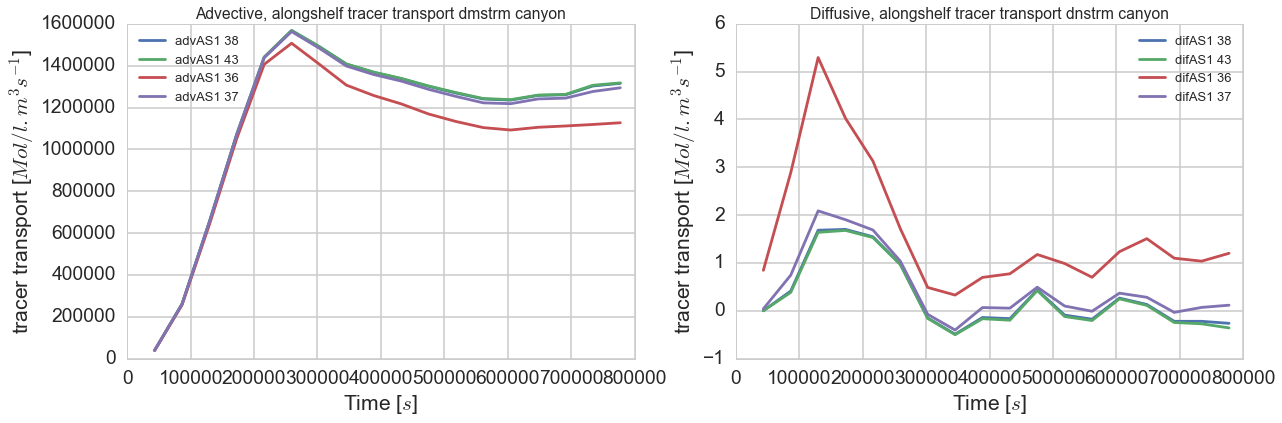

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advAS1c_flux38).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS1 38')
(advAS1c_flux43).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS1 43')
(advAS1c_flux36).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS1 36')
(advAS1c_flux37).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS1 37')

(difAS1c_flux38).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS1 38')
(difAS1c_flux43).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS1 43')
(difAS1c_flux36).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS1 36')
(difAS1c_flux37).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS1 37')


ax[0] = fig_looks(ax[0],title='Advective, alongshelf tracer transport dmstrm canyon')
ax[1] = fig_looks(ax[1],title='Diffusive, alongshelf tracer transport dnstrm canyon')

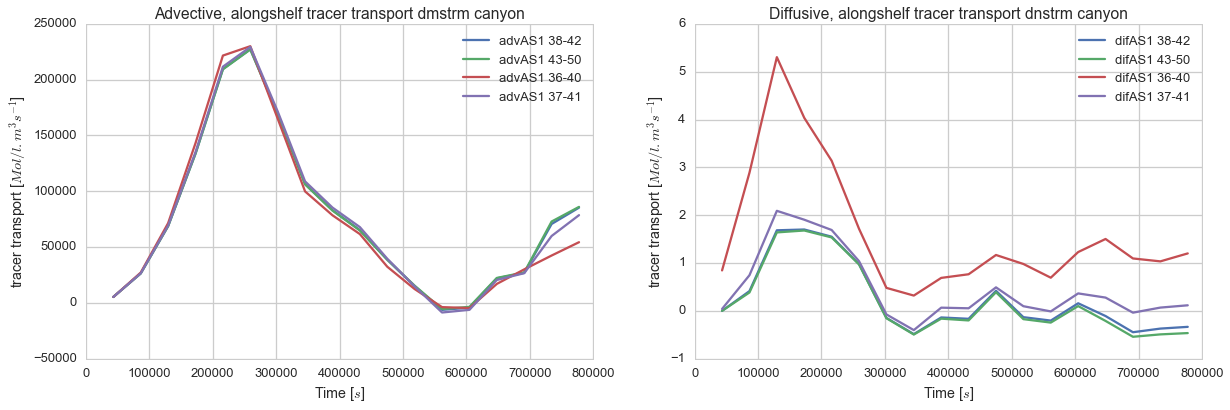

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advAS1c_flux38-advAS1c_flux42).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS1 38-42')
(advAS1c_flux43-advAS1c_flux50).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS1 43-50')
(advAS1c_flux36-advAS1c_flux40).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS1 36-40')
(advAS1c_flux37-advAS1c_flux41).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS1 37-41')

(difAS1c_flux38-difAS1c_flux42).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS1 38-42')
(difAS1c_flux43-difAS1c_flux50).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS1 43-50')
(difAS1c_flux36-difAS1c_flux40).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS1 36-40')
(difAS1c_flux37-difAS1c_flux41).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS1 37-41')


ax[0] = fig_looks(ax[0],title='Advective, alongshelf tracer transport dmstrm canyon')
ax[1] = fig_looks(ax[1],title='Diffusive, alongshelf tracer transport dnstrm canyon')

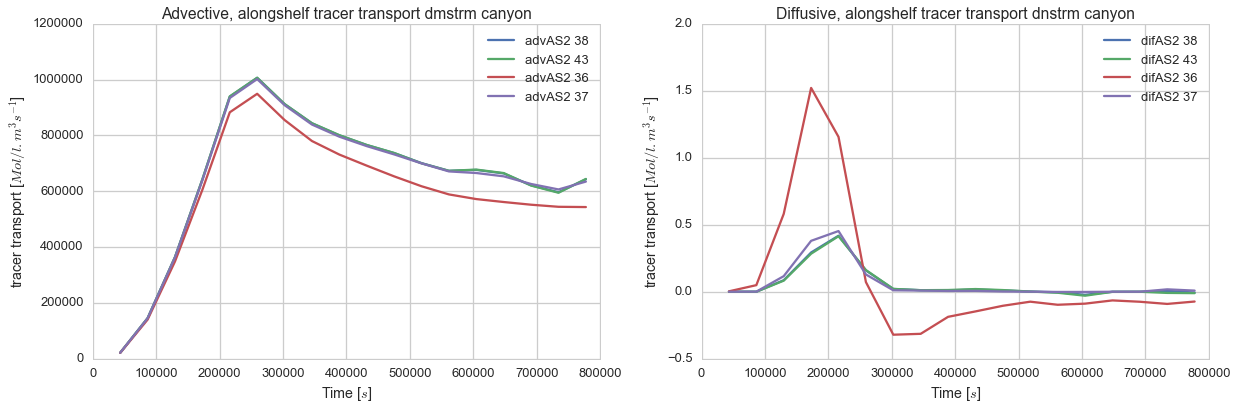

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advAS2c_flux38).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS2 38')
(advAS2c_flux43).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS2 43')
(advAS2c_flux36).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS2 36')
(advAS2c_flux37).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS2 37')

(difAS2c_flux38).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS2 38')
(difAS2c_flux43).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS2 43')
(difAS2c_flux36).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS2 36')
(difAS2c_flux37).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS2 37')


ax[0] = fig_looks(ax[0],title='Advective, alongshelf tracer transport dmstrm canyon')
ax[1] = fig_looks(ax[1],title='Diffusive, alongshelf tracer transport dnstrm canyon')

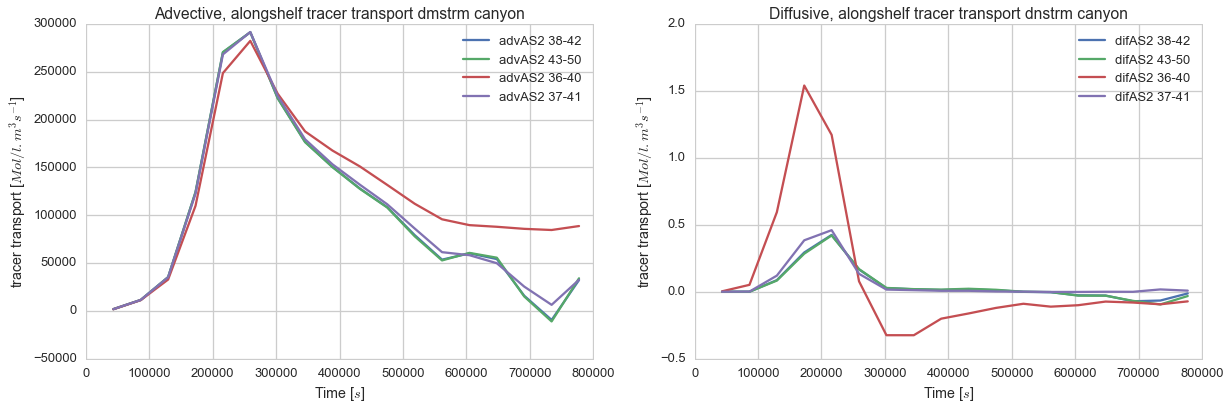

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advAS2c_flux38-advAS2c_flux42).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS2 38-42')
(advAS2c_flux43-advAS2c_flux50).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS2 43-50')
(advAS2c_flux36-advAS2c_flux40).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS2 36-40')
(advAS2c_flux37-advAS2c_flux41).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS2 37-41')

(difAS2c_flux38-difAS2c_flux42).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS2 38-42')
(difAS2c_flux43-difAS2c_flux50).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS2 43-50')
(difAS2c_flux36-difAS2c_flux40).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS2 36-40')
(difAS2c_flux37-difAS2c_flux41).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS2 37-41')


ax[0] = fig_looks(ax[0],title='Advective, alongshelf tracer transport dmstrm canyon')
ax[1] = fig_looks(ax[1],title='Diffusive, alongshelf tracer transport dnstrm canyon')

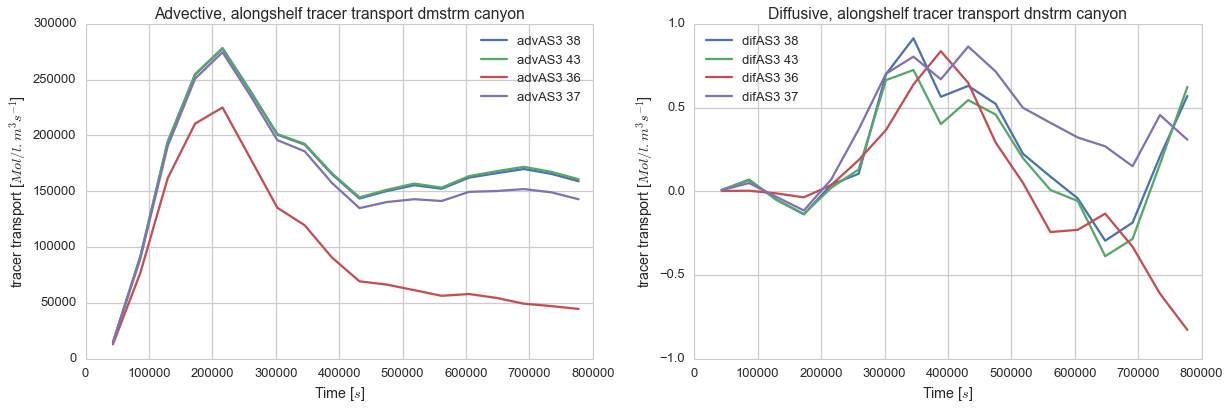

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advAS3c_flux38).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS3 38')
(advAS3c_flux43).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS3 43')
(advAS3c_flux36).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS3 36')
(advAS3c_flux37).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS3 37')

(difAS3c_flux38).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS3 38')
(difAS3c_flux43).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS3 43')
(difAS3c_flux36).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS3 36')
(difAS3c_flux37).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS3 37')


ax[0] = fig_looks(ax[0],title='Advective, alongshelf tracer transport dmstrm canyon')
ax[1] = fig_looks(ax[1],title='Diffusive, alongshelf tracer transport dnstrm canyon')

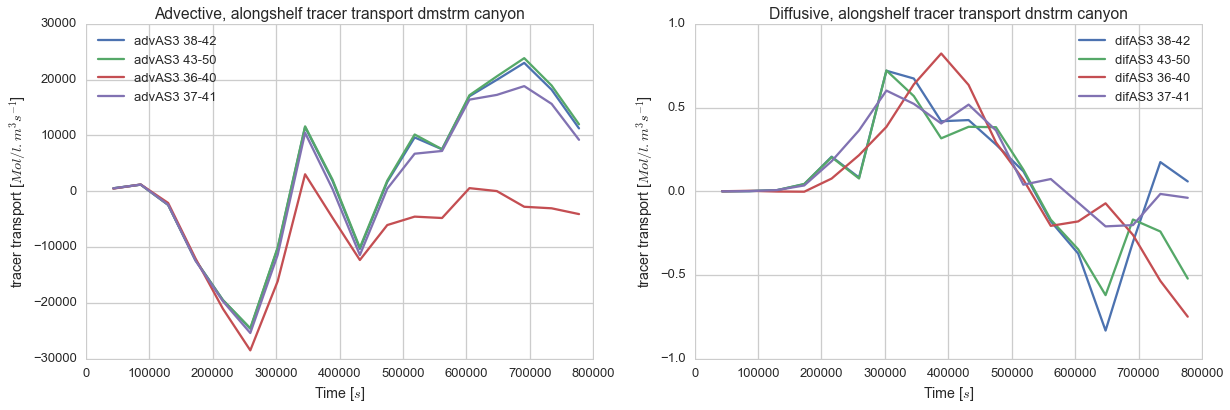

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

(advAS3c_flux38-advAS3c_flux42).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS3 38-42')
(advAS3c_flux43-advAS3c_flux50).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS3 43-50')
(advAS3c_flux36-advAS3c_flux40).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS3 36-40')
(advAS3c_flux37-advAS3c_flux41).sum(dim='Zmd000090').plot(ax=ax[0], label = 'advAS3 37-41')

(difAS3c_flux38-difAS3c_flux42).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS3 38-42')
(difAS3c_flux43-difAS3c_flux50).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS3 43-50')
(difAS3c_flux36-difAS3c_flux40).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS3 36-40')
(difAS3c_flux37-difAS3c_flux41).sum(dim='Zmd000090').plot(ax=ax[1], label = 'difAS3 37-41')


ax[0] = fig_looks(ax[0],title='Advective, alongshelf tracer transport dmstrm canyon')
ax[1] = fig_looks(ax[1],title='Diffusive, alongshelf tracer transport dnstrm canyon')

### Vertical transport at shelf break depth (only within the canyon)


In [7]:
advVR1_flux38 = (unstagger_xarray(flux38.ADVrTr01,'Zld000090').isel(Zld000090=30, X= slice(120,240), Y=slice(227,267))).sum(dim='X')
difEVR1_flux38 = (unstagger_xarray(flux38.DFrETr01,'Zld000090').isel(Zld000090=30, X= slice(120,240), Y=slice(227,267))).sum(dim='X')
difIVR1_flux38 = (unstagger_xarray(flux38.DFrITr01,'Zld000090').isel(Zld000090=30, X= slice(120,240), Y=slice(227,267))).sum(dim='X')

advVR1_flux43 = (unstagger_xarray(flux43.ADVrTr01,'Zld000090').isel(Zld000090=30, X= slice(120,240), Y=slice(227,267))).sum(dim='X')
difEVR1_flux43 = (unstagger_xarray(flux43.DFrETr01,'Zld000090').isel(Zld000090=30, X= slice(120,240), Y=slice(227,267))).sum(dim='X')
difIVR1_flux43 = (unstagger_xarray(flux43.DFrITr01,'Zld000090').isel(Zld000090=30, X= slice(120,240), Y=slice(227,267))).sum(dim='X')

advVR1_flux36 = (unstagger_xarray(flux36.ADVrTr01,'Zld000090').isel(Zld000090=30, X= slice(120,240), Y=slice(227,267))).sum(dim='X')
difEVR1_flux36 = (unstagger_xarray(flux36.DFrETr01,'Zld000090').isel(Zld000090=30, X= slice(120,240), Y=slice(227,267))).sum(dim='X')
difIVR1_flux36 = (unstagger_xarray(flux36.DFrITr01,'Zld000090').isel(Zld000090=30, X= slice(120,240), Y=slice(227,267))).sum(dim='X')

advVR1_flux37 = (unstagger_xarray(flux37.ADVrTr01,'Zld000090').isel(Zld000090=30, X= slice(120,240), Y=slice(227,267))).sum(dim='X')
difEVR1_flux37 = (unstagger_xarray(flux37.DFrETr01,'Zld000090').isel(Zld000090=30, X= slice(120,240), Y=slice(227,267))).sum(dim='X')
difIVR1_flux37 = (unstagger_xarray(flux37.DFrITr01,'Zld000090').isel(Zld000090=30, X= slice(120,240), Y=slice(227,267))).sum(dim='X')


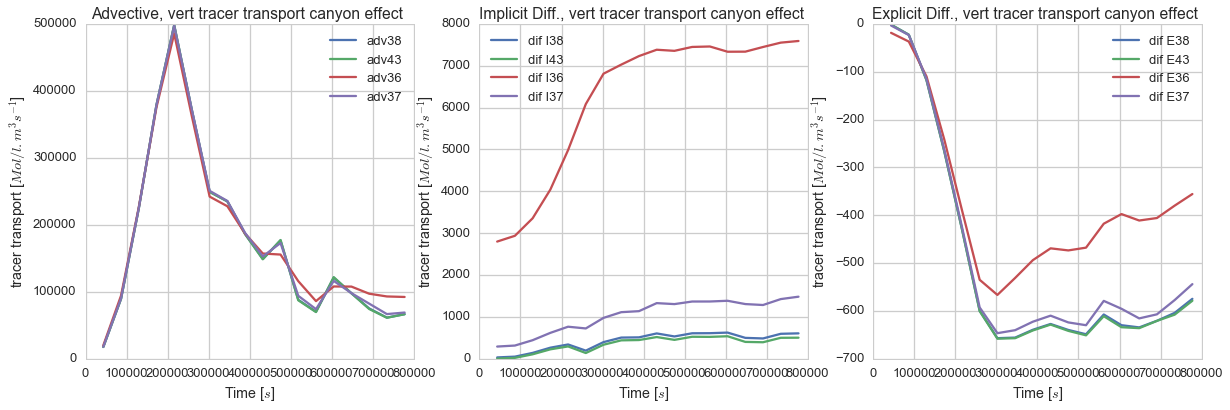

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

(advVR1_flux38).sum(dim='Y').plot(ax=ax[0], label = 'adv38')
(advVR1_flux43).sum(dim='Y').plot(ax=ax[0], label = 'adv43')
(advVR1_flux36).sum(dim='Y').plot(ax=ax[0], label = 'adv36')
(advVR1_flux37).sum(dim='Y').plot(ax=ax[0], label = 'adv37')


(difIVR1_flux38).sum(dim='Y').plot(ax=ax[1], label = 'dif I38')
(difIVR1_flux43).sum(dim='Y').plot(ax=ax[1], label = 'dif I43')
(difIVR1_flux36).sum(dim='Y').plot(ax=ax[1], label = 'dif I36')
(difIVR1_flux37).sum(dim='Y').plot(ax=ax[1], label = 'dif I37')


(difEVR1_flux38).sum(dim='Y').plot(ax=ax[2], label = 'dif E38')
(difEVR1_flux43).sum(dim='Y').plot(ax=ax[2], label = 'dif E43')
(difEVR1_flux36).sum(dim='Y').plot(ax=ax[2], label = 'dif E36')
(difEVR1_flux37).sum(dim='Y').plot(ax=ax[2], label = 'dif E37')


ax[0] = fig_looks(ax[0],title='Advective, vert tracer transport canyon effect ')
ax[1] = fig_looks(ax[1],title='Implicit Diff., vert tracer transport canyon effect ')
ax[2] = fig_looks(ax[2],title='Explicit Diff., vert tracer transport canyon effect ')

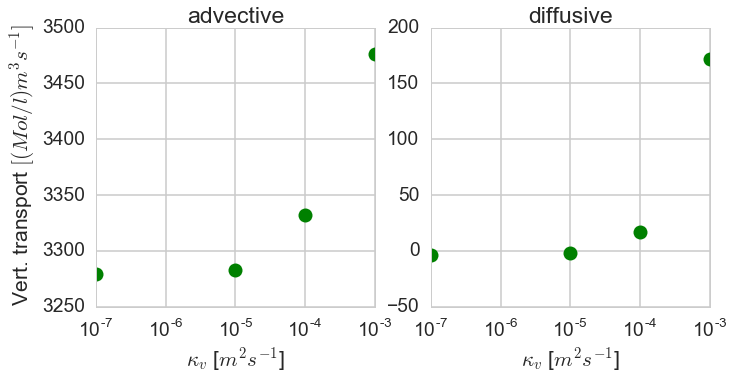

In [11]:
sns.set_context('poster',font_scale=1.2)


datasetsA = [advVR1_flux43,advVR1_flux38,advVR1_flux37,advVR1_flux36]
datasetsD = [difIVR1_flux43+difEVR1_flux43,difIVR1_flux38+difEVR1_flux38,
             difIVR1_flux37+difEVR1_flux37,difIVR1_flux36+difEVR1_flux36]

Kv = [1E-7,1E-5,1E-4,1E-3]

fig,ax = plt.subplots(1,2,figsize=(11,5))

for data,dataV,ii in zip(datasetsA,datasetsD,range(len(Kv)+1)):
    
    ax[0].plot(Kv[ii],data[6:].mean(),'go',markersize=14)
    ax[0].set_xscale("log", nonposx='clip')
    ax[1].plot(Kv[ii],dataV[6:].mean(),'go',markersize=14)
    ax[1].set_xscale("log", nonposx='clip')
    
ax[0].set_ylabel(' Vert. transport $[(Mol/l)m^3s^{-1}]$')
ax[0].set_xlabel('$\kappa_v$ [$m^2s^{-1}$]')
ax[0].set_title('advective')


ax[1].set_xlabel('$\kappa_v$ [$m^2s^{-1}$]')
ax[1].set_title('diffusive')


plt.plot()

fig.savefig('adv_trac_vert_diff_new_visc.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')
